# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2023

## Homework 11
Due Wednesday, April 19

### Graph functions from lecture notes

Below we copy the `Graph` type from the lecture notes, and some of the
functions that we will need.

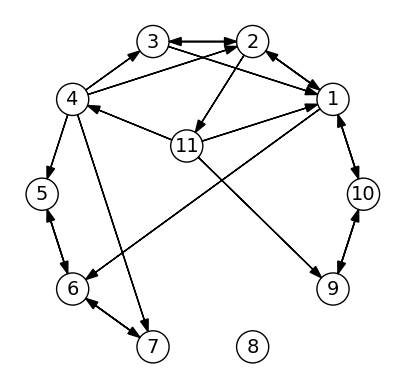

In [1]:
using PyPlot, SparseArrays   # Packages needed

struct Vertex
    neighbors::Vector{Int}       # Indices of neighbors of this Vertex
    coordinates::Vector{Float64} # 2D coordinates of this Vertex - only for plotting
    Vertex(neighbors; coordinates=[0,0]) = new(neighbors, coordinates)
end

function Base.show(io::IO, v::Vertex)
    print(io, "Neighbors = ", v.neighbors)
end

struct Graph
    vertices::Vector{Vertex}
end

function Base.show(io::IO, g::Graph)
    for i = 1:length(g.vertices)
        println(io, "Vertex $i, ", g.vertices[i])
    end
end

function PyPlot.plot(g::Graph; scale=1.0)
    fig, ax = subplots()
    ax.set_aspect("equal")
    
    xmin = minimum(v.coordinates[1] for v in g.vertices)
    xmax = maximum(v.coordinates[1] for v in g.vertices)
    ymin = minimum(v.coordinates[2] for v in g.vertices)
    ymax = maximum(v.coordinates[2] for v in g.vertices)
    sz = max(xmax-xmin, ymax-ymin)
    cr = scale*0.05sz
    hw = cr/2
    axis([xmin-2cr,xmax+2cr,ymin-2cr,ymax+2cr])
    axis("off")

    for i in 1:length(g.vertices)
        c = g.vertices[i].coordinates
        ax.add_artist(matplotlib.patches.Circle(c, cr, facecolor="none", edgecolor="k"))
        ax.text(c[1], c[2], string(i),
                horizontalalignment="center", verticalalignment="center", fontsize=round(Int, 14*scale))
        for nb in g.vertices[i].neighbors
            cnb = g.vertices[nb].coordinates
            dc = cnb .- c
            L = sqrt(sum(dc.^2))
            c1 = c .+ cr/L * dc
            c2 = cnb .- cr/L * dc
            arrow(c1[1], c1[2], c2[1]-c1[1], c2[2]-c1[2],
                  head_width=hw, length_includes_head=true, facecolor="k")
        end
    end
end

function shortest_path_bfs(g::Graph, start, finish)
    parent = zeros(Int64, length(g.vertices))
    S = [start]
    parent[start] = start
    while !isempty(S)
        ivertex = popfirst!(S)
        if ivertex == finish
            break
        end
        for nb in g.vertices[ivertex].neighbors
            if parent[nb] == 0 # Not visited yet
                parent[nb] = ivertex
                push!(S, nb)
            end
        end
    end
    # Build path
    path = Int64[]
    iv = finish
    while true
        pushfirst!(path, iv)
        if iv == start
            break
        end
        iv = parent[iv]
    end
    return path
end

# Example graph from lecture notes
all_neighbors = [[2,10,6], [3,1,11], [1,2], [5,3,2,7], [6],
                 [7,5], [6], Int64[], [10], [1,9], [1,4,9]]
all_coordinates = [[0.81, 0.59], [0.31, 0.95], [-0.31, 0.95], [-0.81, 0.59],
                   [-1.0, 0.0],  [-0.81, -0.59], [-0.31, -0.95], [0.31, -0.95],
                   [0.81, -0.59], [1.0, -0.0], [-0.1, 0.3]]
g = Graph([Vertex(n,coordinates=c) for (n,c) in zip(all_neighbors, all_coordinates)])
plot(g)

### Problem 1 - Graph to adjacency matrix

Write a function `convert2adjmatrix(g::Graph)` which creates a sparse adjacency
matrix for the graph `g`. That is, a matrix $A$ of size $|V|$-by-$|V|$ where
$|V|$ is the number of vertices, and $A_{ij}=1$ if there is an edge from vertex
$i$ to vertex $j$ (otherwise zero).

Make sure you do not insert elements into an existing sparse matrix. Instead,
create vectors of row / column indices, and call `sparse` once to create the
matrix.

In [2]:
function convert2adjmatrix(g::Graph)
    n = length(g.vertices)
    rows = []
    cols = []
    vals = []
    for i = 1:n
        for j = 1:n
            if j in g.vertices[i].neighbors
                push!(rows, i)
                push!(cols, j)
                push!(vals, 1)
            else
                push!(rows, i)
                push!(cols, j)
                push!(vals, 0)
            end            
        end
    end
    return sparse(rows, cols, vals)
end


convert2adjmatrix (generic function with 1 method)

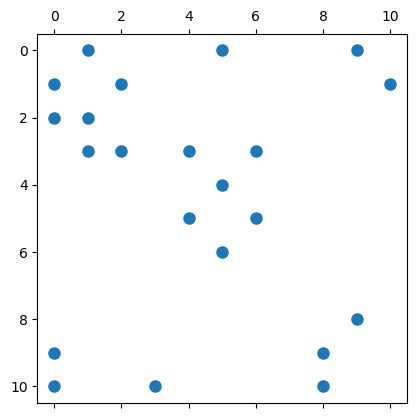

In [3]:
# For testing
A = convert2adjmatrix(g)
spy(A, marker=".", markersize=16);

### Problem 2 - Spanning tree

One application of the DFS algorithm is to generate a spanning tree for a graph,
that is, an acyclic graph for the nodes reachable from a given starting node.
Write a function

```julia
function spanning_tree(g::Graph, start)
```

which returns a new graph
`gtree` with the same vertices as `g`, but only the edges that are traversed
by the DFS method starting from vertex `start`. That is, an edge from `ivertex`
to a neighbor `nb` is only included in `gtree` if the DFS method visits `nb`.

Hint: First initialize `gtree` to a graph with no edges (but the same `coordinates`
as `g`, for plotting). Then you run the DFS method and add edges to `gtree`.

In [15]:
function spanning_tree(g::Graph, start)
    #vertices = [Vertex([], coordinates=g.vertices[i].coordinates) for i = 1:length(g.vertices)]
    vertices = []
    for i = 1:length(g.vertices)
        push!(vertices, Vertex([], coordinates=g.vertices[i].coordinates))
    end
    gtree = Graph(vertices)
    
    function dfs(g::Graph, start)
        visited = falses(length(g.vertices))
        function visit(ivertex)
            visited[ivertex] = true
            #println("Visiting vertex #$ivertex")
            #gtree.vertices[ivertex].neighbors[1:end] = g.vertices[ivertex].neighbors[1:end]
            #[push!(gtree.vertices[ivertex].neighbors, i) for i in g.vertices[ivertex].neighbors]
            for i in g.vertices[ivertex].neighbors
                push!(gtree.vertices[ivertex].neighbors, i)
            end
            for nb in g.vertices[ivertex].neighbors
                if !visited[nb]
                    visit(nb)
                end
            end
        end
        visit(start)
        return nothing
    end
    dfs(g, start)
    return gtree
end

spanning_tree (generic function with 1 method)

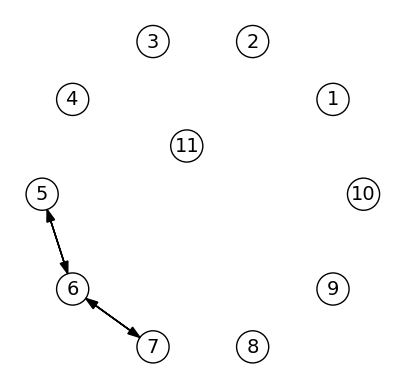

In [16]:
# For testing
gtree = spanning_tree(g, 5)
plot(gtree)

### Problem 3 - Word ladder

A *word ladder* is a sequence of words, beginning at `first_word` and ending at `last_word`,
such that

1. Only one letter is changed in each step
2. Each word exists in a given word list

Write a function

```julia
function word_ladder(first_word, last_word)
```

which returns the *shortest* such sequence of words. You can assume that
the sequence exists, if it is not unique you can return any shortest
sequence, and that the lengths of the two given words are equal.
Use the same word list as in homework 8 (that is,
<https://github.com/BenLauwens/ThinkJulia.jl/blob/master/data/words.txt>).

**Algorithm**: 

1. Read the word list into an array of string, but only keep the ones of the same
   length as the given two words.
   
2. Create a graph where these words are vertices, and an edge between words $i,j$
   if the corresponding words only differ in one character.
   
3. Run the `shortest_path_bfs` function on the graph, with start and finish indices
   corresponding to the given two words. Use the path to output the sequence of words.
   
**Example**:

```julia
word_ladder("fool", "sage")
```
```
7-element Array{String,1}:
 "fool"
 "foil"
 "fail"
 "fall"
 "sall"
 "sale"
 "sage"
```


In [9]:
function word_ladder(first_word, last_word)
    words = [line for line in eachline("words.txt") if length(line) == length(first_word)]
    vertices = [Vertex([]) for i in words]
    indS = -1
    indE = -1
    for i = 1:length(words)
        if words[i] == first_word
            indS = i
        elseif words[i] == last_word
            indE = i
        end
        for j = 1:length(words)
            word1 = words[i]
            word2 = words[j]
            if word1 != word2
                diff = 0
                for k = 1:length(word1)
                    if word1[k] != word2[k]
                        diff += 1
                    end
                end
                if diff == 1
                    push!(vertices[i].neighbors, j)
                end
            end
        end
    end
    word_tree = Graph(vertices)
    word_path = [words[i] for i in shortest_path_bfs(Graph(vertices), indS, indE)]
    return word_path
end

word_ladder (generic function with 1 method)

In [10]:
# For testing
word_ladder("fool", "sage")

7-element Vector{String}:
 "fool"
 "foil"
 "fail"
 "fall"
 "sall"
 "sale"
 "sage"